In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import h5py
import glob

In [2]:
folder='data/'

In [3]:
# to read the ligo data 
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'].value
    #print meta.keys()
    utc=meta['UTCstart'].value
    duration=meta['Duration'].value
    strain=dataFile['strain']['Strain'].value
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [4]:
"""This is the data we are using. We can use any of the data sets it will not vchange the analyis just uncomment it
we will be using the first data sit since what is the piont if we aren't looking at the first gravitational wave"""

[datah, dth, utch]=read_file(folder+'H-H1_LOSC_4_V2-1126259446-32.hdf5')
[datal, dtl ,utcl]=read_file(folder+'L-L1_LOSC_4_V2-1126259446-32.hdf5')
[th, tl]=read_template(folder+'GW150914_4_template.hdf5')


# [datah, dth, utch]=read_file(folder+'H-H1_LOSC_4_V2-1128678884-32.hdf5')
# [datal, dtl ,utcl]=read_file(folder+'L-L1_LOSC_4_V2-1128678884-32.hdf5')
# [th, tl]=read_template(folder+'LVT151012_4_template.hdf5')


# [datah, dth, utch]=read_file(folder+'H-H1_LOSC_4_V2-1135136334-32.hdf5')
# [datal, dtl ,utcl]=read_file(folder+'L-L1_LOSC_4_V2-1135136334-32.hdf5')
# [th, tl]=read_template(folder+'GW151226_4_template.hdf5')

# [datah, dth, utch]=read_file(folder+'H-H1_LOSC_4_V1-1167559920-32.hdf5')
# [datal, dtl ,utcl]=read_file(folder+'L-L1_LOSC_4_V1-1167559920-32.hdf5')
# [th, tl]=read_template(folder+'GW170104_4_template.hdf5')


/opt/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [5]:
time=np.zeros(len(datah))+dth
time[0]=0
time=np.cumsum(time)
#defining time pionts

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


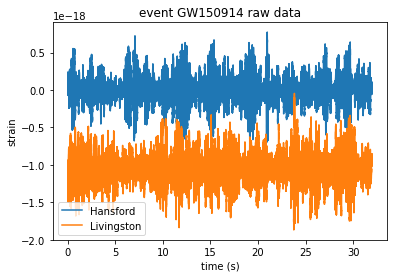

In [6]:
plt.plot(time,datah,label='Hansford')
plt.plot(time,datal,label='Livingston')
plt.title('event GW150914 raw data')
plt.xlabel("time (s)")
plt.ylabel('strain')
plt.legend()
plt.show()

We can see that the data is imposible to see without an appropriate noise model


In [7]:
#using a Nuttall window 
x=np.zeros(len(datah))+1
x[0]=0
x=np.cumsum(x)

N=len(datah)
ao=0.355768
a1=0.487396
a2=0.144232
a3=0.012604
window=ao-a1*np.cos(2*np.pi*x/N)+a2*np.cos(4*np.pi*x/N)-a3*np.cos(6*np.pi*x/N)


In [8]:
#taking windowed fourier transforms of everything 
FTh=np.fft.rfft(datah*window)
FTl=np.fft.rfft(datal*window)
FTth=np.fft.rfft(th*window)
FTtl=np.fft.rfft(tl*window)

freq=np.fft.fftfreq(len(FTh),dth)
freq=np.fft.fftshift(freq) # finding our frequncy and shifting them so they make sense


In [9]:
PSh=(np.abs(FTh)**2)
PSl=(np.abs(FTl)**2)
from scipy.ndimage import gaussian_filter
PSh=gaussian_filter(PSh,10)
PSl=gaussian_filter(PSl,10)

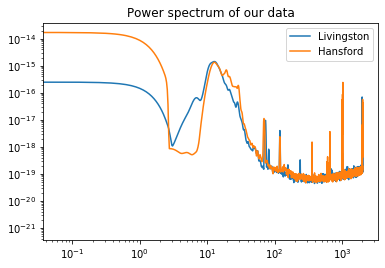

In [10]:
plt.close
plt.loglog(freq,np.sqrt(np.fft.fftshift(PSh)),label='Livingston') 
plt.loglog(freq,np.sqrt(np.fft.fftshift(PSl)),label='Hansford')
#plotting the PS with the appropiarte frequncies the shift is PS is so they match on the plot
plt.title('Power spectrum of our data')
plt.legend()
plt.show()

This is our noise model we took the power spectrum of our data used a Nuttal window since its spreads out very little power. I smoothed the data using a gaussian filter. This was done for both Livingston and Hansford

1b

In [11]:
#whitening our data by dividing by the sqrt of the noise models 

white_datahF=FTh/np.sqrt(PSh)
white_datah=np.fft.irfft(white_datahF)
white_thF=FTth/np.sqrt(PSh)
white_th=np.fft.irfft(white_thF)
wavehF=white_datahF*np.conj(white_thF)
waveh=np.fft.irfft(wavehF)
waveh=np.fft.fftshift(waveh)

white_datalF=FTl/np.sqrt(PSl)
white_datal=np.fft.irfft(white_datalF)
white_tlF=FTtl/np.sqrt(PSl)
white_tl=np.fft.irfft(white_tlF)
wavelF=white_datalF*np.conj(white_tlF)
wavel=np.fft.irfft(wavelF)
wavel=np.fft.fftshift(wavel)




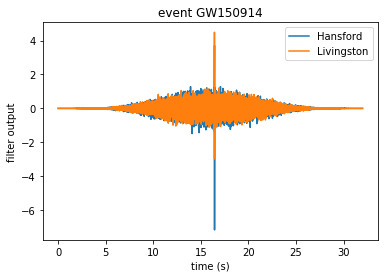

In [12]:
plt.plot(time,waveh,label='Hansford')
plt.plot(time,wavel,label='Livingston')
plt.title('event GW150914')
plt.xlabel("time (s)")
plt.ylabel("filter output")
plt.legend()
plt.show()

Looks we have found our gravitational wave 

1c

To get $SNR^2$ we will devide the sqaure of the fourier transform of the template by the power spectrum of the noise

In [13]:
SNR2hF=((FTth**2)/PSh)
SNR2lF=((FTtl**2)/PSl) #finding SNR2 if fourier space first
SNRh=np.fft.irfft(np.sqrt(SNR2hF))
SNRh=np.fft.fftshift(SNRh) #making sure the time is alligned right
SNRl=np.fft.irfft(np.sqrt(SNR2lF))
SNRl=np.fft.fftshift(SNRl)

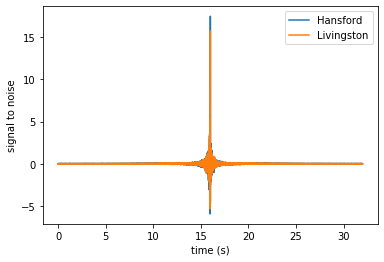

In [14]:
plt.plot(time,SNRh,label='Hansford')
plt.plot(time,SNRl,label='Livingston')
plt.xlabel("time (s)")
plt.ylabel("signal to noise")
plt.legend()
plt.show()

1d

In [15]:
ih=np.argmax(waveh) #finding the lopcation of  the wave assuming its the highest piont in the peak
SNRmeh=waveh[ih]/np.std(waveh[ih-1000:ih+1000])
print('anyltic signal to noise is ',np.max(SNRh),'we get ',SNRmeh,'for Hansford')


il=np.argmax(wavel)
SNRmel=wavel[il]/np.std(wavel[il-1000:il+1000])
print('anyltic signal to noise is ',np.max(SNRl),'we get ',SNRmel,'for Livingston')


anyltic signal to noise is  17.462313633042868 we get  5.432592882269912 for Hansford
anyltic signal to noise is  15.71484087561413 we get  9.242112188981219 for Livingston


The reason we see a lower signal to noise ratio is the analytic signal to noise ratio assumes a perfect noise model, we unfourtanetly live in the real world where nothing is perfect so of course our noise model does not perfectly describe the signal so we will get a lower than ideal signal to noise ratio

1e

In [22]:
PSh=np.abs(white_datahF)**2
PSl=np.abs(white_datalF)**2


scaledPSh=np.cumsum(PSh)/np.sum(PSh)
scaledPSl=np.cumsum(PSl)/np.sum(PSl)
#these go from 0 to 1 we want to find the piont where its 1/2
halfpth=np.argmin(np.abs(scaledPSh-1/2))
halfptl=np.argmin(np.abs(scaledPSl-1/2))

print('the half way pionts we find are',np.abs(freq[halfpth]),'Hz and',np.abs(freq[halfptl]),"Hz")

the half way pionts we find are 0.8124876024230587 Hz and 18.874711994751056 Hz


1f

array([-2.8896792 +0.00000000e+00j,  1.98905341+6.69847762e-06j,
       -0.59420689-1.11010172e-04j, ..., -0.38365181+1.23875545e+00j,
        0.15774843-8.93250098e-01j, -0.08949146+0.00000000e+00j])

In [28]:
np.argmin(scaledPSh-1/2)

array([4.64599014e-04, 9.25631231e-04, 1.37960823e-03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [32]:
utcln

b'2015-09-14T09:50:30'

Note the start time is 09:50 and 30 sec on september 14th 2015 

In [33]:
print('the event was meassued at',time[ih],'in the Hansford site')
print('the event was meassued at',time[il],'in the Livingston site')

the event was meassued at 16.43701171875 in the Hansford site
the event was meassued at 16.431640625 in the Livingston site


This is expected as graviational waves proegate at the speed of light and the two sited are order $10^6m$ appart so we expect a delay in the millisecond range the error in loclization then would come enitrely in the certainity of the time of arrival of gravtiational wave which depends on sampeling frequncy